In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.metrics import confusion_matrix
import itertools

# Download NLTK resources
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

color = sns.color_palette()
%matplotlib inline

# Inisialisasi stopwords
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [93]:
## Baca dataset dan liat jumlah baris setiap dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("Jumlah baris di train dataset : ",train_df.shape[0])
print("Jumlah baris di test dataset : ",test_df.shape[0])

Jumlah baris di train dataset :  19579
Jumlah baris di test dataset :  8392


In [94]:
## Mendefinisikan fitur-fitur yang akan digunakan

## Total kata yang dipake di teks ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Total kata unik yang dipake di teks ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Total karakter yang dipake di teks ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Total stopwords yang dipake di teks ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Total tanda baca yang dipake di teks ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Total kata dengan kapitalisasi penuh yang dipake di teks ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Total kata dengan kapitalisasi di awal yang dipake di teks ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Rata-rata jumlah kata yang dipake di masing-masing teks ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

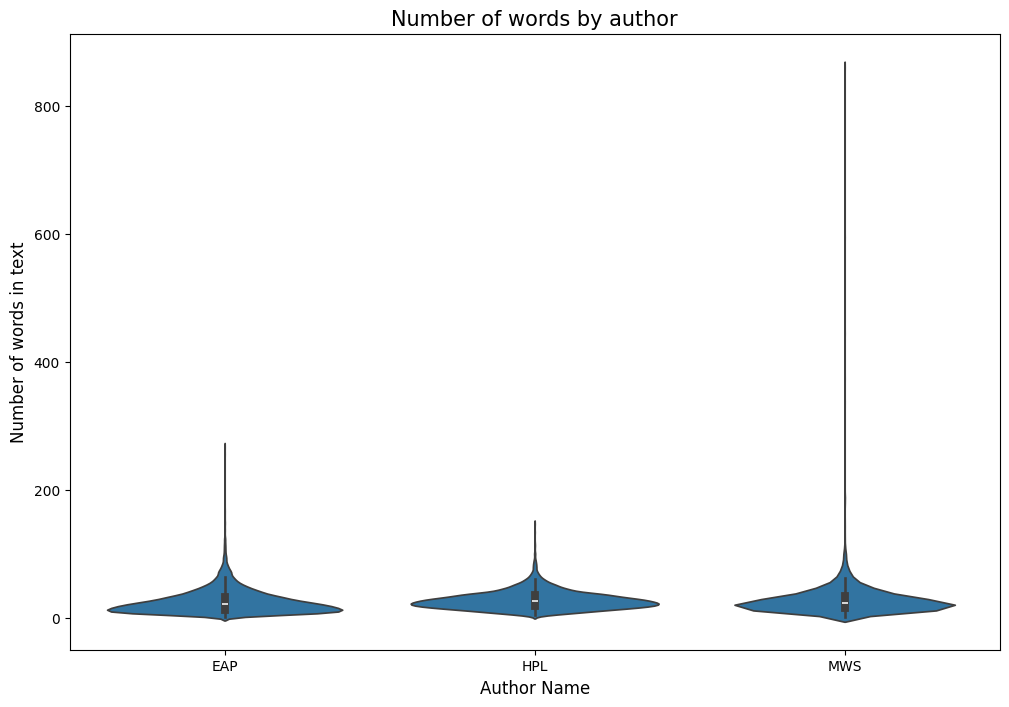

C:\Users\fayza\AppData\Local\Temp\ipykernel_25428\720845866.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_words'].loc[train_df['num_words']>80] = 80


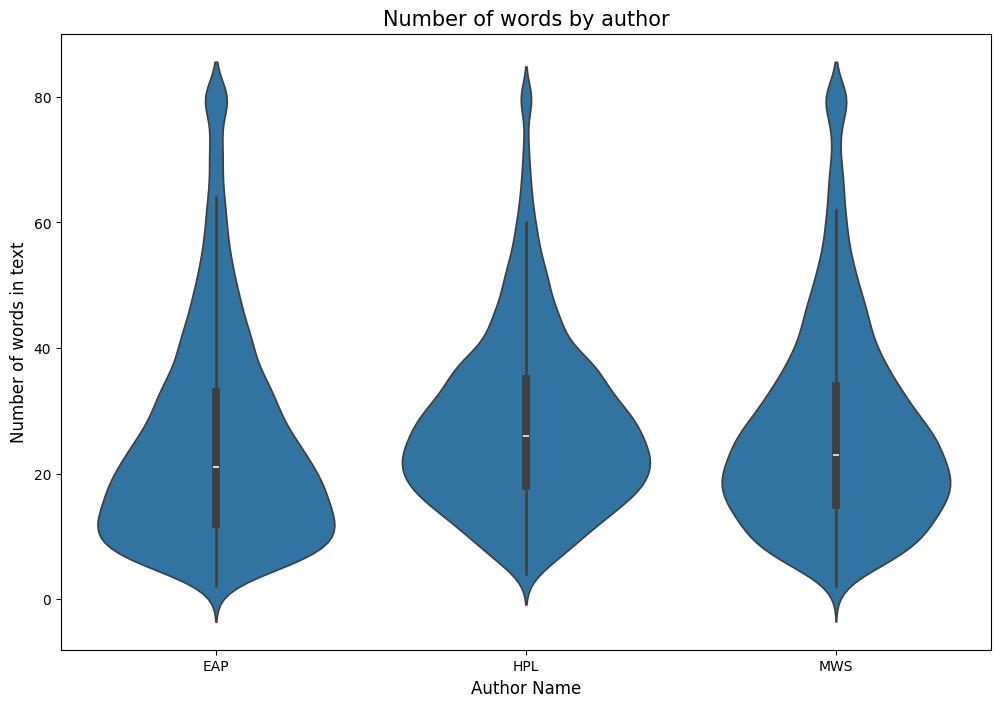

In [95]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

train_df['num_words'].loc[train_df['num_words']>80] = 80

plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

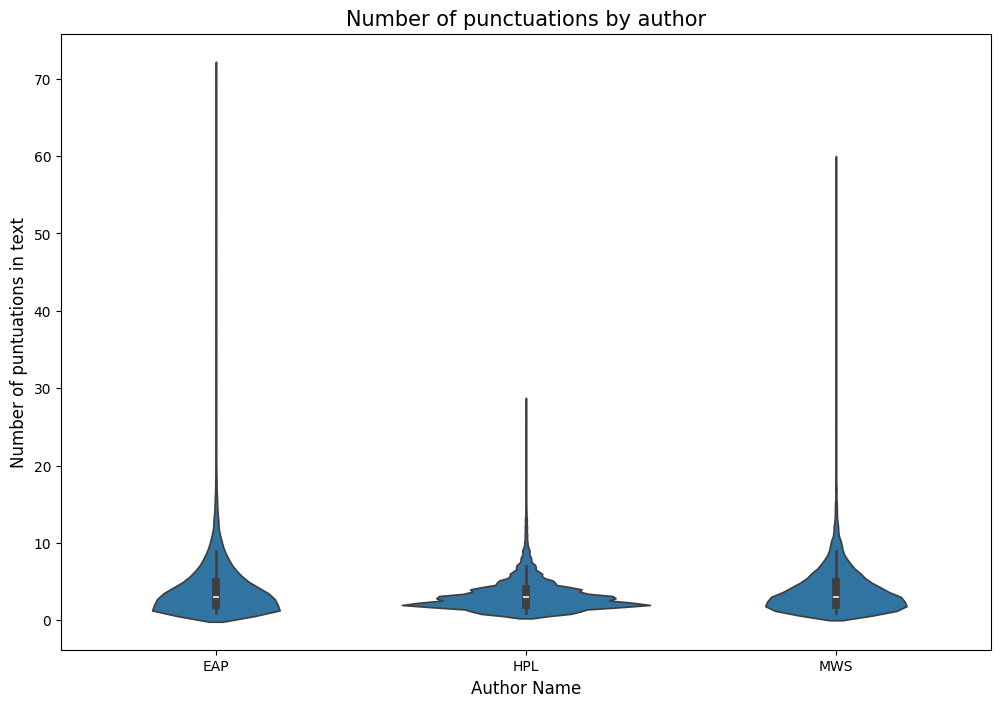

C:\Users\fayza\AppData\Local\Temp\ipykernel_25428\1088783329.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10


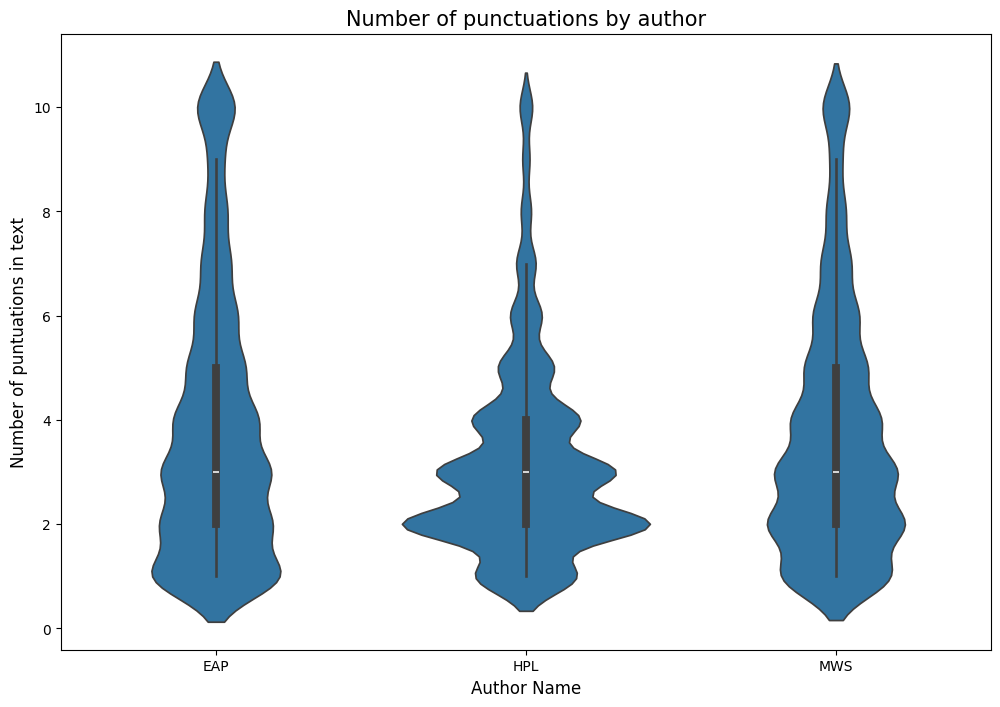

In [96]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10

plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [ ]:
## Menyiapkan data untuk pembuatan model dengan memberi label numerik
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### Komputasi ulang variabel yang ditruncate
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

train_df.head()

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481


In [98]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {
        'objective': 'multi:softprob',
        'eta': 0.1,
        'max_depth': 3,
        'verbosity': 0,
        'num_class': 3,
        'eval_metric': "mlogloss",
        'min_child_weight': child,
        'subsample': 0.8,
        'colsample_bytree': colsample,
        'seed': seed_val
    }
    num_rounds = 2000
    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X.values, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X.values, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X.values)
        model = xgb.train(plst, xgtrain, num_rounds)

    if hasattr(model, 'best_ntree_limit'):
        pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    else:
        pred_test_y = model.predict(xgtest)

    pred_test_y2 = None
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2.values)
        if hasattr(model, 'best_ntree_limit'):
            pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
        else:
            pred_test_y2 = model.predict(xgtest2)

    return pred_test_y, pred_test_y2, model


In [99]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09476	test-mlogloss:1.09554
[20]	train-mlogloss:1.04222	test-mlogloss:1.05296
[40]	train-mlogloss:1.01973	test-mlogloss:1.03510
[60]	train-mlogloss:1.00690	test-mlogloss:1.02455
[80]	train-mlogloss:0.99638	test-mlogloss:1.01759


C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-mlogloss:0.98894	test-mlogloss:1.01260
[120]	train-mlogloss:0.98327	test-mlogloss:1.00932
[140]	train-mlogloss:0.97766	test-mlogloss:1.00647
[160]	train-mlogloss:0.97249	test-mlogloss:1.00380
[180]	train-mlogloss:0.96772	test-mlogloss:1.00136
[200]	train-mlogloss:0.96396	test-mlogloss:0.99983
[220]	train-mlogloss:0.96033	test-mlogloss:0.99843
[240]	train-mlogloss:0.95666	test-mlogloss:0.99685
[260]	train-mlogloss:0.95325	test-mlogloss:0.99581
[280]	train-mlogloss:0.95014	test-mlogloss:0.99458
[300]	train-mlogloss:0.94753	test-mlogloss:0.99399
[320]	train-mlogloss:0.94462	test-mlogloss:0.99303
[340]	train-mlogloss:0.94205	test-mlogloss:0.99279
[360]	train-mlogloss:0.93950	test-mlogloss:0.99240
[380]	train-mlogloss:0.93676	test-mlogloss:0.99174
[400]	train-mlogloss:0.93453	test-mlogloss:0.99123
[420]	train-mlogloss:0.93256	test-mlogloss:0.99112
[440]	train-mlogloss:0.93043	test-mlogloss:0.99052
[460]	train-mlogloss:0.92866	test-mlogloss:0.99062
[480]	train-mlogloss:0.92675	te

C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[120]	train-mlogloss:0.98606	test-mlogloss:0.99703
[140]	train-mlogloss:0.98070	test-mlogloss:0.99470
[160]	train-mlogloss:0.97526	test-mlogloss:0.99150
[180]	train-mlogloss:0.97042	test-mlogloss:0.98910
[200]	train-mlogloss:0.96652	test-mlogloss:0.98738
[220]	train-mlogloss:0.96299	test-mlogloss:0.98601
[240]	train-mlogloss:0.95926	test-mlogloss:0.98392
[260]	train-mlogloss:0.95572	test-mlogloss:0.98271
[280]	train-mlogloss:0.95255	test-mlogloss:0.98193
[300]	train-mlogloss:0.95021	test-mlogloss:0.98117
[320]	train-mlogloss:0.94736	test-mlogloss:0.98078
[340]	train-mlogloss:0.94490	test-mlogloss:0.98061
[360]	train-mlogloss:0.94248	test-mlogloss:0.97997
[380]	train-mlogloss:0.93993	test-mlogloss:0.97950
[400]	train-mlogloss:0.93772	test-mlogloss:0.97919
[420]	train-mlogloss:0.93569	test-mlogloss:0.97902
[440]	train-mlogloss:0.93343	test-mlogloss:0.97862
[460]	train-mlogloss:0.93163	test-mlogloss:0.97830
[480]	train-mlogloss:0.92995	test-mlogloss:0.97848
[500]	train-mlogloss:0.92812	te

C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[140]	train-mlogloss:0.97737	test-mlogloss:1.00662
[160]	train-mlogloss:0.97165	test-mlogloss:1.00331
[180]	train-mlogloss:0.96674	test-mlogloss:1.00112
[200]	train-mlogloss:0.96304	test-mlogloss:0.99976
[220]	train-mlogloss:0.95947	test-mlogloss:0.99829
[240]	train-mlogloss:0.95589	test-mlogloss:0.99654
[260]	train-mlogloss:0.95268	test-mlogloss:0.99552
[280]	train-mlogloss:0.94982	test-mlogloss:0.99464
[300]	train-mlogloss:0.94730	test-mlogloss:0.99377
[320]	train-mlogloss:0.94449	test-mlogloss:0.99262
[340]	train-mlogloss:0.94197	test-mlogloss:0.99194
[360]	train-mlogloss:0.93968	test-mlogloss:0.99132
[380]	train-mlogloss:0.93713	test-mlogloss:0.99024
[400]	train-mlogloss:0.93503	test-mlogloss:0.98977
[420]	train-mlogloss:0.93302	test-mlogloss:0.98962
[440]	train-mlogloss:0.93092	test-mlogloss:0.98919
[460]	train-mlogloss:0.92916	test-mlogloss:0.98898
[480]	train-mlogloss:0.92743	test-mlogloss:0.98875
[500]	train-mlogloss:0.92549	test-mlogloss:0.98850
[520]	train-mlogloss:0.92376	te

C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[120]	train-mlogloss:0.98426	test-mlogloss:1.00275
[140]	train-mlogloss:0.97845	test-mlogloss:0.99994
[160]	train-mlogloss:0.97304	test-mlogloss:0.99654
[180]	train-mlogloss:0.96813	test-mlogloss:0.99381
[200]	train-mlogloss:0.96439	test-mlogloss:0.99215
[220]	train-mlogloss:0.96079	test-mlogloss:0.99081
[240]	train-mlogloss:0.95728	test-mlogloss:0.98908
[260]	train-mlogloss:0.95370	test-mlogloss:0.98783
[280]	train-mlogloss:0.95073	test-mlogloss:0.98718
[300]	train-mlogloss:0.94830	test-mlogloss:0.98669
[320]	train-mlogloss:0.94549	test-mlogloss:0.98599
[340]	train-mlogloss:0.94301	test-mlogloss:0.98570
[360]	train-mlogloss:0.94057	test-mlogloss:0.98482
[380]	train-mlogloss:0.93789	test-mlogloss:0.98437
[400]	train-mlogloss:0.93573	test-mlogloss:0.98395
[420]	train-mlogloss:0.93361	test-mlogloss:0.98359
[440]	train-mlogloss:0.93125	test-mlogloss:0.98325
[460]	train-mlogloss:0.92943	test-mlogloss:0.98305
[480]	train-mlogloss:0.92755	test-mlogloss:0.98337
[500]	train-mlogloss:0.92562	te

C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[120]	train-mlogloss:0.98612	test-mlogloss:1.00040
[140]	train-mlogloss:0.98086	test-mlogloss:0.99739
[160]	train-mlogloss:0.97512	test-mlogloss:0.99409
[180]	train-mlogloss:0.97016	test-mlogloss:0.99169
[200]	train-mlogloss:0.96637	test-mlogloss:0.98996
[220]	train-mlogloss:0.96302	test-mlogloss:0.98870
[240]	train-mlogloss:0.95926	test-mlogloss:0.98650
[260]	train-mlogloss:0.95597	test-mlogloss:0.98487
[280]	train-mlogloss:0.95296	test-mlogloss:0.98376
[300]	train-mlogloss:0.95053	test-mlogloss:0.98327
[320]	train-mlogloss:0.94772	test-mlogloss:0.98198
[340]	train-mlogloss:0.94535	test-mlogloss:0.98134
[360]	train-mlogloss:0.94292	test-mlogloss:0.98055
[380]	train-mlogloss:0.94029	test-mlogloss:0.97931
[400]	train-mlogloss:0.93814	test-mlogloss:0.97861
[420]	train-mlogloss:0.93611	test-mlogloss:0.97831
[440]	train-mlogloss:0.93387	test-mlogloss:0.97765
[460]	train-mlogloss:0.93193	test-mlogloss:0.97772
[480]	train-mlogloss:0.93009	test-mlogloss:0.97743
[500]	train-mlogloss:0.92838	te

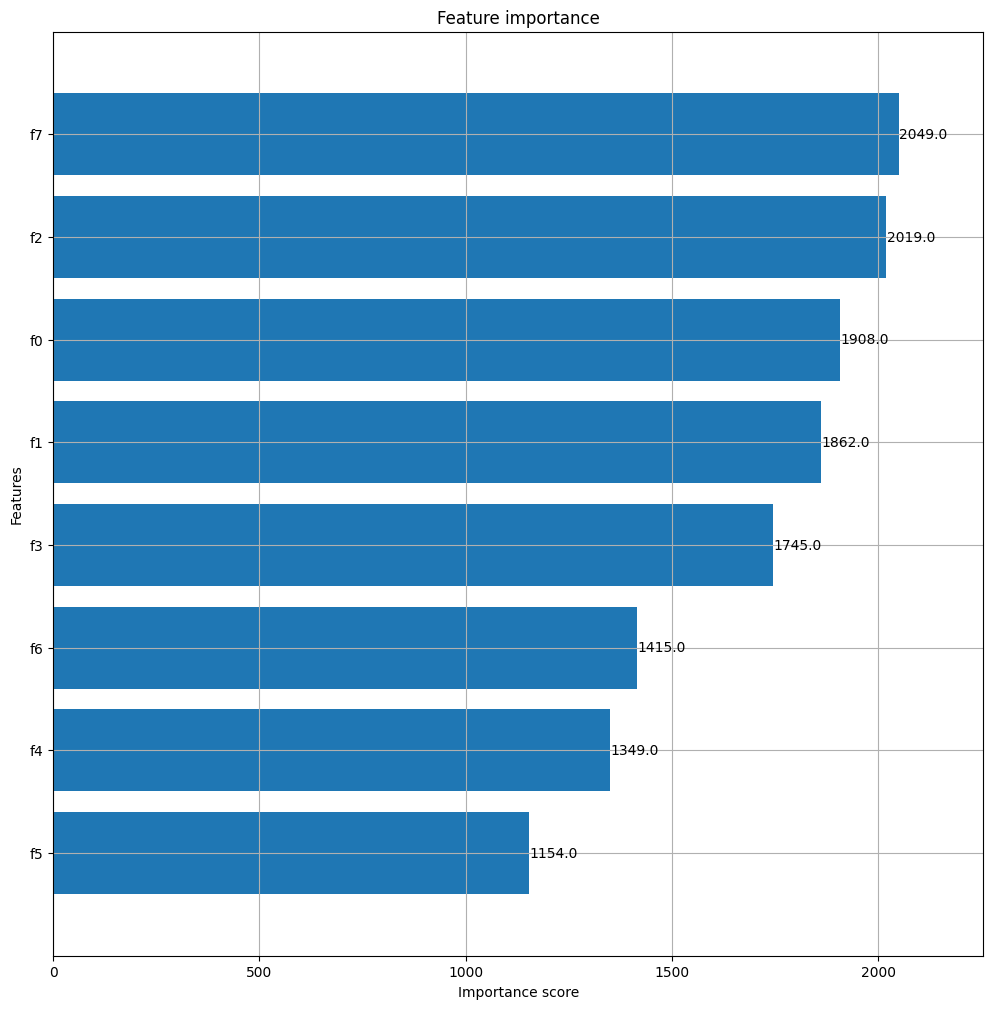

In [ ]:
### Melihat fitur-fitur yang bobotnya paling tinggi/penting
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
### Mempelajari vocab gabungan data train dan test, dan mengubahnya menjadi bentuk vector tfidf
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())

## Membentuk vector berdasarkan vocab yang telah dipelajari
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
def runMNB(train_X, train_y, test_X, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [103]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612853


In [ ]:
### Membuat confusion matrix untuk visualisasi 
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    #label sumbu x dan y
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

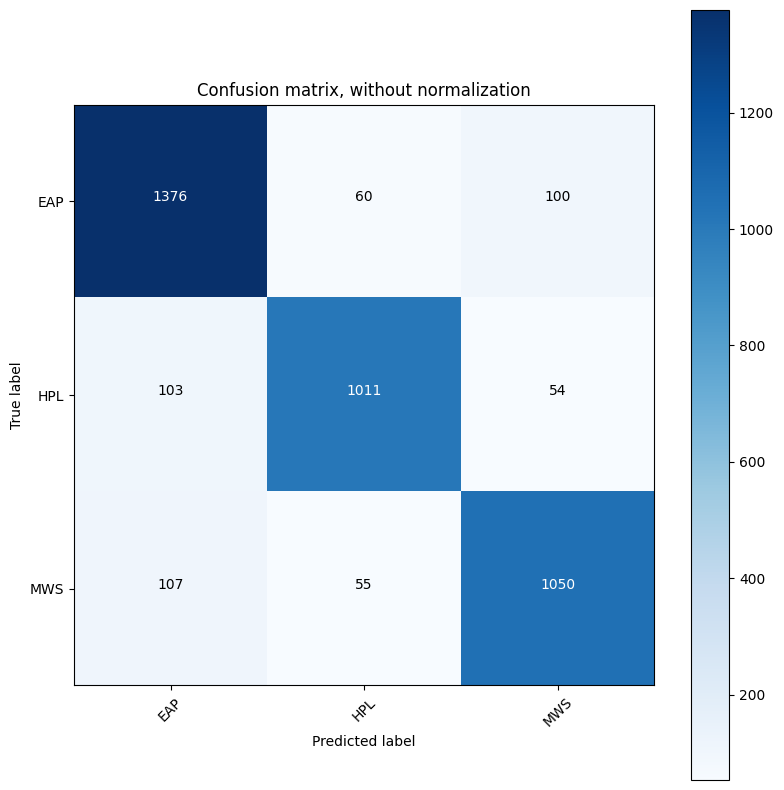

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Menggambarkan confusion matrix yang belum dinormalisasi
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
#melakukan reduksi pada dimensi vektor
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

#membuat vektor pada 
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
#menghitung jumlah kemunculan kata atau n-gram pada teks (Count Vectorizer)
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
#melakukan training dengan cross-validation dan menghitung prediksi
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

#menambahkan penghitungan prediksi sebagai fitur baru
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.4509184161656742


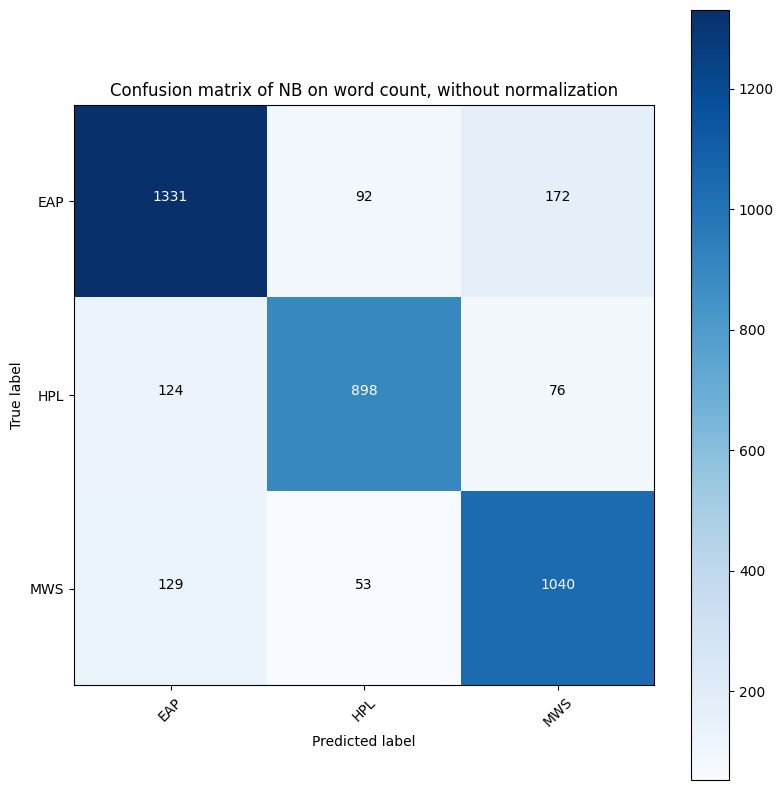

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Menggambarkan confusion matrix yang tidak dinormalisasi
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [ ]:
#menghitung jumlah kemunculan karakter dalam n-gram 1-7
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.8528982526171456


In [ ]:
### Mempelajari vocab gabungan data train dan test, dan mengubahnya menjadi bentuk vector tfidf
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947422


In [ ]:
#reduksi vektor tfidf dengan SVD dengan konfigurasi yang sama seperti sebelumnya
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

#training vektor tfidf yang telah direduksi dengan XGBoost
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00540	test-mlogloss:1.00491
[20]	train-mlogloss:0.41086	test-mlogloss:0.41593


C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[40]	train-mlogloss:0.34038	test-mlogloss:0.35144
[60]	train-mlogloss:0.31469	test-mlogloss:0.33306
[80]	train-mlogloss:0.29732	test-mlogloss:0.32396
[100]	train-mlogloss:0.28391	test-mlogloss:0.31791
[120]	train-mlogloss:0.27238	test-mlogloss:0.31403
[140]	train-mlogloss:0.26306	test-mlogloss:0.31180
[160]	train-mlogloss:0.25441	test-mlogloss:0.30976
[180]	train-mlogloss:0.24662	test-mlogloss:0.30860
[200]	train-mlogloss:0.23956	test-mlogloss:0.30759
[220]	train-mlogloss:0.23288	test-mlogloss:0.30727
[240]	train-mlogloss:0.22646	test-mlogloss:0.30682
[260]	train-mlogloss:0.22029	test-mlogloss:0.30660
[280]	train-mlogloss:0.21463	test-mlogloss:0.30603
[300]	train-mlogloss:0.20903	test-mlogloss:0.30577
[320]	train-mlogloss:0.20384	test-mlogloss:0.30584
[340]	train-mlogloss:0.19866	test-mlogloss:0.30556
[360]	train-mlogloss:0.19384	test-mlogloss:0.30531
[380]	train-mlogloss:0.18882	test-mlogloss:0.30581
[400]	train-mlogloss:0.18404	test-mlogloss:0.30562
[410]	train-mlogloss:0.18174	test-

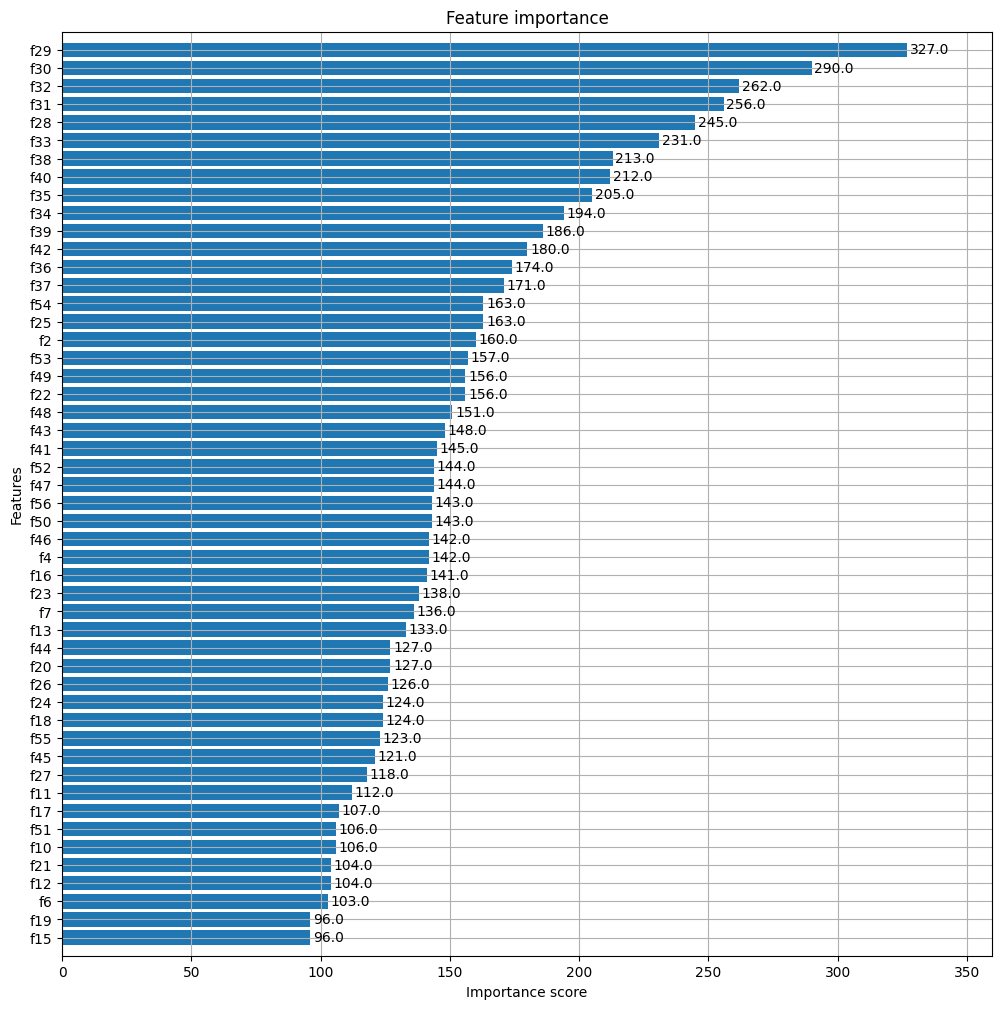

In [ ]:
### Menggambarkan variabel-variabel yang penting
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

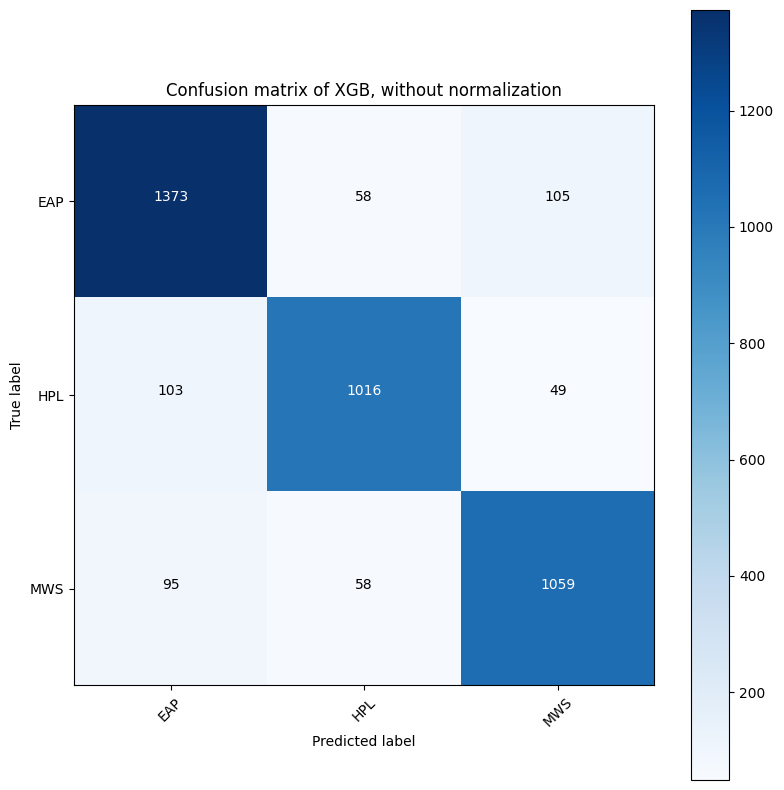

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
test_tfidf = tfidf_vectorizer.transform(test_df['text'])

# Gabungkan TF-IDF train dan test
full_tfidf = sparse.vstack([train_tfidf, test_tfidf])


In [117]:
from sklearn.decomposition import TruncatedSVD

n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)

train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]

train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)


In [ ]:
# Naive Bayes pada kemunculan kata atau n-gram 1-3
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)

#training vektor tfidf yang telah direduksi dengan MNB
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv score:", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score: 0.4509184161656742


In [119]:
# Add predictions as new features
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

In [ ]:
# Naive Bayes pada kemunculan karakter atau n-gram 1-7
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)

#training vektor tfidf yang telah direduksi dengan MNB
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv score:", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score: 3.8528982526171456


In [ ]:
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

In [ ]:
# Naive Bayes pada karakter dengan vektor tfidf
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)

#dilatih dengan MNB
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv score:", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score: 0.790415258947422


In [ ]:
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

In [ ]:
# SVD pada karakter TFIDF
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [ ]:
# Model XGBoost akhir dengan semua fitur penting
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

# Pastikan semua kolom numerik
train_X = train_X.astype(float)
test_X = test_X.astype(float)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

#menjalankan training dengan XGB
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

print("CV scores:", cv_scores)


[0]	train-mlogloss:1.00689	test-mlogloss:1.00662
[20]	train-mlogloss:0.41249	test-mlogloss:0.41710


C:\Users\fayza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[40]	train-mlogloss:0.34004	test-mlogloss:0.35239
[60]	train-mlogloss:0.31338	test-mlogloss:0.33357
[80]	train-mlogloss:0.29572	test-mlogloss:0.32382
[100]	train-mlogloss:0.28217	test-mlogloss:0.31743
[120]	train-mlogloss:0.27078	test-mlogloss:0.31353
[140]	train-mlogloss:0.26063	test-mlogloss:0.31154
[160]	train-mlogloss:0.25178	test-mlogloss:0.31016
[180]	train-mlogloss:0.24370	test-mlogloss:0.30871
[200]	train-mlogloss:0.23643	test-mlogloss:0.30856
[220]	train-mlogloss:0.22923	test-mlogloss:0.30797
[240]	train-mlogloss:0.22233	test-mlogloss:0.30697
[260]	train-mlogloss:0.21633	test-mlogloss:0.30636
[280]	train-mlogloss:0.21026	test-mlogloss:0.30667
[300]	train-mlogloss:0.20444	test-mlogloss:0.30672
[303]	train-mlogloss:0.20358	test-mlogloss:0.30680
CV scores: [0.3067998892375266]


In [ ]:
# Prediksi akhir
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("kel7_submission.csv", index=False)
from google.colab import files
files.download('kel7_submission.csv')


Submission file created successfully!


ModuleNotFoundError: No module named 'google.colab'